In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('path to local MGWR repository copy')

from mgwr.gwr import GWR
from spglm.family import Gaussian, Binomial, Poisson
from mgwr.gwr import MGWR,MGWRResults
from mgwr.sel_bw import Sel_BW
import libpysal as ps

import gstools as gs
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import seaborn as sns


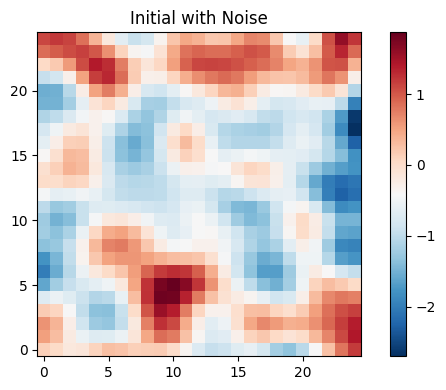

In [3]:
dimensionxy=25

# 生成数据
x = np.linspace(0, 25, 25)
y = np.linspace(0, 25, 25)
XX, YY = np.meshgrid(x, y)

# 第一个数据
model = gs.Gaussian(dim=2, var=1, len_scale=3.01)
srf = gs.SRF(model,mean=0.)
srf((x, y), mesh_type='structured')
B0=srf((x, y), mesh_type='structured',seed=100)

# x = np.linspace(0, 50, 50)
# y = np.linspace(0, 50, 50)
# XX, YY = np.meshgrid(x, y)
# # #第一个数据
# model = gs.Gaussian(dim=2, var=1,len_scale=6.5)
# srf = gs.SRF(model,mean=0.)
# srf((x, y), mesh_type='structured')
# B0=srf((x, y), mesh_type='structured',seed=100)

# model = gs.Gaussian(dim=2, var=2,len_scale=6)

# dimensionxy=80

# x = np.linspace(0, dimensionxy, dimensionxy)
# y = np.linspace(0, dimensionxy, dimensionxy)
# XX, YY = np.meshgrid(x, y)
# #第一个数据

# model = gs.Gaussian(dim=2, var=2,len_scale=10)
# srf = gs.SRF(model,mean=0.)
# srf((x, y), mesh_type='structured')
# B0=srf((x, y), mesh_type='structured',seed=100)


# # 可视化
fig, axes = plt.subplots(1, 1, figsize=(6, 4))

# 原始随机场带噪声
im0 = axes.imshow(B0, origin='lower', cmap='RdBu_r')
axes.set_title('Initial with Noise')
fig.colorbar(im0, ax=axes)


plt.tight_layout()
plt.show()


In [4]:

import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer



#-----------------------
# 定义状态数
n_states = 5
est = KBinsDiscretizer(n_bins=n_states, encode='ordinal', strategy='uniform')
B_discretized = est.fit_transform(B0)

def process_data_with_randomness(B_discretized):
    # 构建转移概率矩阵
    transition_matrix = np.zeros((n_states, n_states))

    for month in range(dimensionxy-1):  # 24次状态转移
        for day in range(dimensionxy):
            current_state = int(B_discretized[month, day])
            next_state = int(B_discretized[month + 1, day])
            transition_matrix[current_state, next_state] += 1

    # 归一化转移概率矩阵
    transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)

    # 使用马尔可夫链预测第26个月的状态
    last_month_states = B_discretized[-1, :]
    predicted_states = []

    for state in last_month_states:
        predicted_state = np.random.choice(np.arange(n_states), p=transition_matrix[int(state)])
        predicted_states.append(predicted_state)

    # print(predicted_states)
    # return predicted_states
    # 预测值从状态返回到实际值范围
    B26_pred = est.inverse_transform([predicted_states])

    predicted_value=B26_pred.flatten()

    return predicted_value

def calcuCirculation_for_point(B_object, time):
    all_processed_values = []
    results_df = pd.DataFrame()

    # if time == 2:
    #     for i in range(1, time):
    #         processed_value = process_data_with_randomness(B_object)
    #         all_processed_values.append(pd.Series([processed_value], name=f'Out0'))
    #     results_df = pd.concat(all_processed_values, axis=1)
    #     results_df.to_csv("initial-out/pred_nonoisy_initial.csv", index=False)
    if time != 2:
        for i in range(1, time):
            processed_value = process_data_with_randomness(B_object)
            all_processed_values.append(pd.Series(processed_value, name=f'Out{i}'))
        results_df = pd.concat(all_processed_values, axis=1)
        results_df.to_csv("repro-out/pred_nonoisy.csv", index=False)
        # 检查结果
        print(results_df)

times = 1001
# calcuCirculation_for_point(B_discretized, 2)
calcuCirculation_for_point(B_discretized, times)



        Out1      Out2      Out3      Out4      Out5      Out6      Out7  \
0   0.807272  0.807272  0.183373 -0.440525  0.807272  0.807272  0.183373   
1   0.929124  0.929124  0.929124  0.929124  0.929124 -0.169475  0.929124   
2   0.878734  0.878734  0.878734  0.878734  0.878734 -0.125788  0.878734   
3   0.928482  0.504334  0.928482  0.928482  0.504334  0.928482  0.504334   
4   0.572737  0.572737  1.120895  1.120895  0.572737  0.024580  0.572737   
5  -0.035987 -0.573472  1.038982 -1.110957  1.038982 -0.573472 -0.035987   
6  -0.703686 -0.256841 -0.703686 -0.256841 -1.150531 -1.150531 -0.703686   
7  -0.490053 -1.351977 -1.351977 -0.921015 -0.921015 -0.490053 -0.921015   
8  -0.576425 -0.576425 -0.576425 -0.051503  0.473419 -0.576425 -0.051503   
9  -0.293056 -0.293056 -0.293056 -0.293056 -0.293056 -0.895922 -0.293056   
10 -0.109377  1.589522 -0.109377 -0.109377  1.023222  1.589522  1.023222   
11 -0.044175 -0.044175 -0.044175  0.445020 -0.044175  0.445020 -0.044175   
12  0.635022

In [5]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from itertools import combinations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import shapiro

import warnings 

warnings.filterwarnings("ignore")

df = pd.read_csv("./repro-out/pred_nonoisy.csv")
out0 = pd.read_csv("./initial-out/pred_nonoisy_initial.csv")
data = df




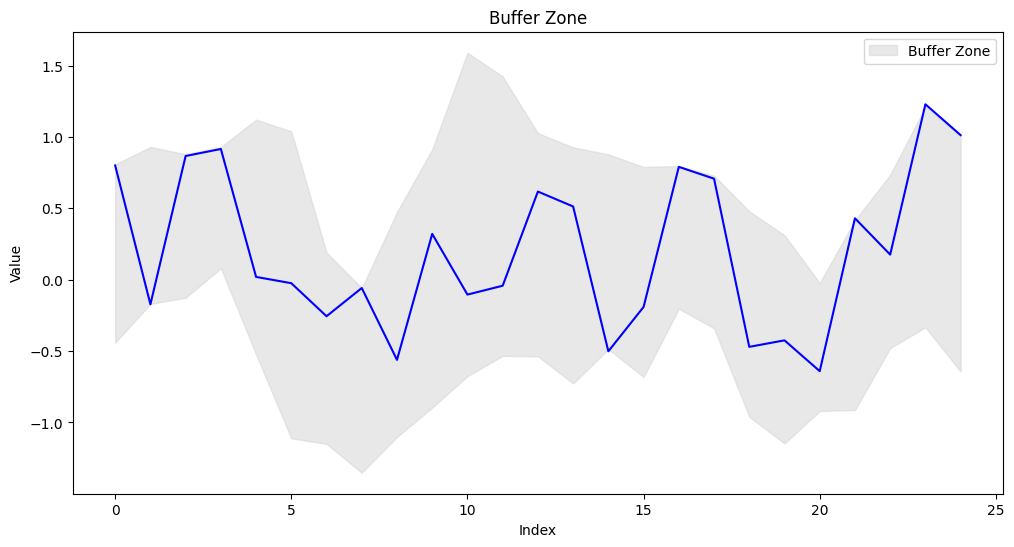

19 25
76.0


In [6]:
def calculate_proportion(values, lower_bound, upper_bound):
    # 确保所有输入都是 NumPy 数组
    if isinstance(values, pd.Series):
        values = values.to_numpy().flatten()
    if isinstance(lower_bound, pd.Series):
        lower_bound = lower_bound.to_numpy().flatten()
    if isinstance(upper_bound, pd.Series):
        upper_bound = upper_bound.to_numpy().flatten()
    
    common_count = 0
    total_count = len(values)
    
    for value, lb, ub in zip(values, lower_bound, upper_bound):
        # print(value, lb, ub)
        if lb <= value <= ub:
            common_count += 1
    print(common_count, total_count)
    return common_count / total_count*100

# 初始化缓冲区上下界的数组
buffer_upper = []
buffer_lower = []

# 获取列的范围
start_col = data.columns.get_loc("Out1")
end_col = data.columns.get_loc("Out1000") + 1

# 对每一行进行正态性检验并计算缓冲区
for i in range(data.shape[0]):
    row_data = data.iloc[i, start_col:end_col]    
    buffer_upper.append(max(row_data))
    buffer_lower.append(min(row_data))

# 将缓冲区上下界转换为数组
buffer_upper = np.array(buffer_upper)
buffer_lower = np.array(buffer_lower)

# 生成x轴
x = np.arange(data.shape[0])

# 绘制缓冲区范围
plt.figure(figsize=(12, 6))
# 绘制Out0数据
plt.plot(x,out0, color='blue')

plt.fill_between(x, buffer_lower, buffer_upper, color='lightgray', alpha=0.5, label='Buffer Zone')

# 绘制部分数据列以示例
# for i in range(5):
#     plt.plot(x, data[f"Out{i+1}"], label=f'Out{i+1}', linestyle='--')

plt.legend()
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Buffer Zone')
plt.show()
# 计算Out0在缓冲区内的比例
probability_within_buffer = calculate_proportion(out0.values,buffer_lower,buffer_upper)
print(probability_within_buffer)

In [7]:
# # 生成所需列的列名列表
# df['Out0']=out0

# column_names = [f'Out{i}' for i in range(0, 1001)]
# data_df = df[column_names]



In [8]:


import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from itertools import combinations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import shapiro

import warnings 

warnings.filterwarnings("ignore")

df = pd.read_csv("./repro-out/pred_nonoisy.csv")
out0 = pd.read_csv("./initial-out/pred_nonoisy_initial.csv")

# 生成所需列的列名列表
# df['Out0']=out0

column_names = [f'Out{i}' for i in range(1, 1001)]
data_df = df[column_names]
print(data_df)

        Out1      Out2      Out3      Out4      Out5      Out6      Out7  \
0   0.807272  0.807272  0.183373 -0.440525  0.807272  0.807272  0.183373   
1   0.929124  0.929124  0.929124  0.929124  0.929124 -0.169475  0.929124   
2   0.878734  0.878734  0.878734  0.878734  0.878734 -0.125788  0.878734   
3   0.928482  0.504334  0.928482  0.928482  0.504334  0.928482  0.504334   
4   0.572737  0.572737  1.120895  1.120895  0.572737  0.024580  0.572737   
5  -0.035987 -0.573472  1.038982 -1.110957  1.038982 -0.573472 -0.035987   
6  -0.703686 -0.256841 -0.703686 -0.256841 -1.150531 -1.150531 -0.703686   
7  -0.490053 -1.351977 -1.351977 -0.921015 -0.921015 -0.490053 -0.921015   
8  -0.576425 -0.576425 -0.576425 -0.051503  0.473419 -0.576425 -0.051503   
9  -0.293056 -0.293056 -0.293056 -0.293056 -0.293056 -0.895922 -0.293056   
10 -0.109377  1.589522 -0.109377 -0.109377  1.023222  1.589522  1.023222   
11 -0.044175 -0.044175 -0.044175  0.445020 -0.044175  0.445020 -0.044175   
12  0.635022


计算 ResidualError 统计量:
原始结果与复现结果之间的ResidualError 95%置信区间: (0.2162, 0.5618);随机误差范围: (0.1994, 0.6260)
总误差覆盖随机-置信区间覆盖率: 0.5229；概率0.9583
随机覆盖总-置信区间覆盖率: 0.9608；概率0.9583

计算 MAE 统计量:
原始结果与复现结果之间的MAE 95%置信区间: (0.3081, 0.6037);随机误差范围: (0.2882, 0.6130)
总误差覆盖随机-置信区间覆盖率: 0.4407；概率0.955
随机覆盖总-置信区间覆盖率: 0.9387；概率0.955

计算 RMSE 统计量:
原始结果与复现结果之间的RMSE 95%置信区间: (0.4649, 0.7495);随机误差范围: (0.4447, 0.7901)
总误差覆盖随机-置信区间覆盖率: 0.6077；概率0.9574
随机覆盖总-置信区间覆盖率: 0.9416；概率0.9574


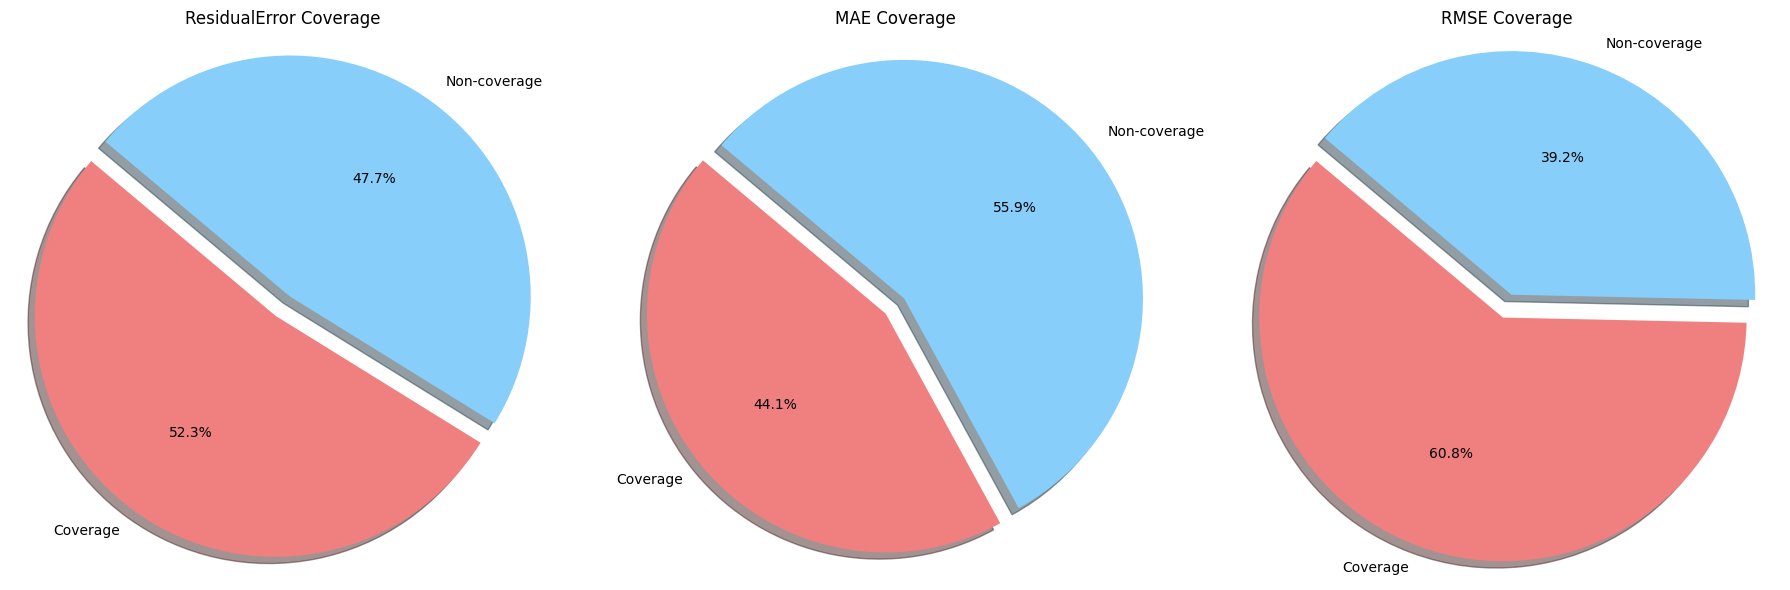

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def calculate_coverage(interval1, interval2):
    L1, U1 = interval1
    L2, U2 = interval2
    L_overlap, U_overlap = max(L1, L2), min(U1, U2)
    if L_overlap > U_overlap:
        return 0.0
    overlap_length = U_overlap - L_overlap
    length1, length2 = U1 - L1, U2 - L2
    coverage = overlap_length / length1
    return coverage 

def calculate_coverage2(interval1, interval2):
    # interval1 总误差
    # interval2 随机误差
    L1, U1 = interval1
    L2, U2 = interval2
    L_overlap, U_overlap = max(L1, L2), min(U1, U2)
    if L_overlap > U_overlap:
        return 0.0
    overlap_length = U_overlap - L_overlap
    length1, length2 = U1 - L1, U2 - L2
    coverage = overlap_length / length2
    return coverage 

def calculate_statistics(data):
    return np.mean(data), np.var(data), np.std(data)

def calculate_confidence_interval(values, alpha=0.05):
    
    values = np.sort(values)
    lower_bound = np.percentile(values, alpha / 2 * 100)
    upper_bound = np.percentile(values, (1 - alpha / 2) * 100)
    return lower_bound, upper_bound

def calculate_proportion(values, lower_bound, upper_bound):
    values = np.asarray(values).flatten()
    
    common_count = 0
    total_count = len(values)
    for value in values:
        if lower_bound <= value <= upper_bound:
            common_count += 1
            
    return common_count / total_count

def lins_ccc(x, y):
    mean_x, mean_y = np.mean(x), np.mean(y)
    var_x, var_y = np.var(x), np.var(y)
    cov_xy = np.mean((x - mean_x) * (y - mean_y))
    rho = cov_xy / np.sqrt(var_x * var_y)
    return (2 * rho * np.sqrt(var_x) * np.sqrt(var_y)) / (var_x + var_y + (mean_x - mean_y)**2)


def calculate_statistic_values(stat_type,outx,outy):
    if stat_type == "R2":
        return r2_score(outx, outy)
    if stat_type == "Lin's CCC":
        return lins_ccc(outx, outy)
    if stat_type=="MAE":
        return mean_absolute_error(outx, outy)
    if stat_type=="MAEP": 
        return np.mean(np.abs((outx - outy) / outx)) * 100
    if stat_type=="RMSE":
        return np.sqrt(mean_squared_error(outx, outy))
    if stat_type=="R2":
        return r2_score(outx, outy)
    if stat_type=="SSE":
        return np.sum((outx - outy) ** 2)
    if stat_type=="ResidualError":

        return np.mean((outx - outy)**2)
    if stat_type=="ResidualError2":
        return np.mean((outx - outy))



def monteCarloMethod(num_samples, data, stat_type):
    monteCarlo_values = []
    sampled_combinations = [np.random.choice(data.columns, 2, replace=False) for _ in range(num_samples)]
    for i, j in sampled_combinations:  
        monteCarlo_values.append(calculate_statistic_values(stat_type,data[i], data[j]))
    return monteCarlo_values

stat_types = ["ResidualError","MAE","RMSE"]

# 创建一个3x1的子图布局
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for idx, stat_type in enumerate(stat_types):
    print(f"\n计算 {stat_type} 统计量:") 

    # real_values = [calculate_statistic_values(stat_type, out0, data_df[f'Out{i}']) for i in range(1, 1001)]
    # real_values = [calculate_statistic_values(stat_type, out0.flatten(), data_df[f'Out{i}'].flatten())  for i in range(1, 1001)]
    real_values = [ calculate_statistic_values(stat_type, out0.values.flatten(), data_df[f'Out{i}'].values.flatten()) for i in range(1, 1001)]
    # print( real_values)

    # 计算置信区间-----总误差
    ci_low, ci_high = calculate_confidence_interval(real_values)
    # -----随机误差
    monteCarlo_values = monteCarloMethod(10000, data_df, stat_type)


    ci_low_mc_random, ci_high_mc_random = calculate_confidence_interval(monteCarlo_values)
    print(f"原始结果与复现结果之间的{stat_type} 95%置信区间: ({ci_low:.4f}, {ci_high:.4f});随机误差范围: ({ci_low_mc_random:.4f}, {ci_high_mc_random:.4f})")
    # 计算覆盖率
    ratio_original = calculate_proportion(monteCarlo_values, ci_low, 1)
    coverage = calculate_coverage((ci_low, 1), (ci_low_mc_random, ci_high_mc_random))
    coverage2 = calculate_coverage2((ci_low, 1), (ci_low_mc_random, ci_high_mc_random))
    print(f"总误差覆盖随机-置信区间覆盖率: {coverage:.4f}；概率{ratio_original}")
    print(f"随机覆盖总-置信区间覆盖率: {coverage2:.4f}；概率{ratio_original}")

    # 绘制覆盖率的饼图
    labels = ['Coverage', 'Non-coverage']
    sizes = [coverage, 1-coverage]
    colors = ['lightcoral', 'lightskyblue']
    explode = (0.1, 0)  # 突出显示覆盖率
    axs[idx].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
                 shadow=True, startangle=140)
    axs[idx].axis('equal')
    axs[idx].set_title(f'{stat_type} Coverage')

plt.tight_layout()
plt.show()


In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
## --Prediction--
# 定义计算指标的函数
def calculate_metrics(true_values, predictions, p):
    mae = mean_absolute_error(true_values, predictions)
    mape = np.mean(np.abs((true_values - predictions) / true_values)) * 100
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    r2 = r2_score(true_values, predictions)
    n = len(true_values)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    sse = np.sum((true_values - predictions) ** 2)
    aic = n * np.log(sse / n) + 2 * (p)
    residual= true_values-predictions

    return mae, mape, rmse, r2, adj_r2, aic,residual.values[0]

p = 7  # 根据你的模型的自变量数量调整
# print(out0.values, data_df['Out1'])
metrics = calculate_metrics(out0.values.flatten(), data_df['Out1'], p)


# 输出结果
print(f"MAE:{round(metrics[0],4)}")
print(f"MAPE:{round(metrics[1],4)}")
print(f"RMSE:{round(metrics[2],4)}")
print(f"R2:{round(metrics[3],4)}")
# print(f"Metrics: Adj.R2:{round(metrics[4],4)}")
# print(f"Metrics: AIC:{round(metrics[5],4)}")
print(f"Residual:{round(metrics[6],4)}")


MAE:0.3796
MAPE:238.8684
RMSE:0.5462
R2:-0.0082
Residual:-0.0075
